# Notes on Chapter 2 of Statistical Rethinking 2nd Edition by Richard McElreath

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfm = tf.math

In [2]:
%load_ext rpy2.ipython

### 2.1

In [3]:
%%R

ways <- c(0, 3, 8, 9, 0)
ways/sum(ways)

[1] 0.00 0.15 0.40 0.45 0.00


In [4]:
ways = tf.constant([0, 3, 8, 9, 0])
ways/tfm.reduce_sum(ways)

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.  , 0.15, 0.4 , 0.45, 0.  ])>

### 2.2

In [5]:
%%R

dbinom(6, size=9, prob=0.5)

[1] 0.1640625


In [6]:
tfd.Binomial(total_count=9, probs=0.5).prob(6)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16406262>

### 2.3

In [7]:
%%R

p_grid <- seq(from=0, to=1, length.out=20)
prior <- rep(1, 20)
likelyhood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelyhood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)

In [37]:
# BUG: Tensorflow probability returns NaNs for some 0 values of the probability density function (e.g. 1.0)
# This will set them to zero (but might have performance implications)
def zero_nans(x):
    return tf.where(tfm.is_nan(x), tf.zeros_like(x), x)

p_grid = tf.linspace(0., 1, 20)
prior = tf.ones_like(p_grid)
likelyhood = zero_nans(tfd.Binomial(total_count=9, probs=p_grid).prob(6))
unnormalized_posterior = likelyhood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)

### 2.4

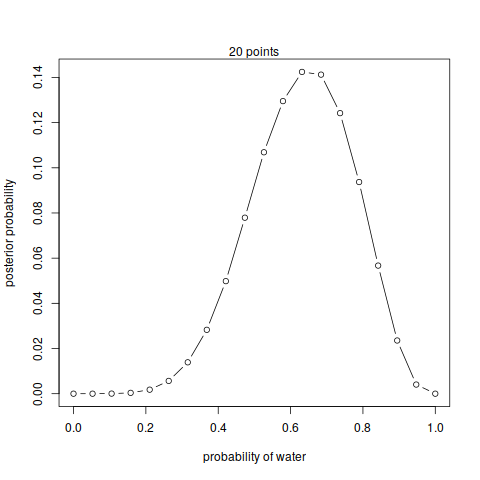

In [38]:
%%R

plot(p_grid, posterior, type="b", xlab="probability of water", ylab="posterior probability")
mtext("20 points")

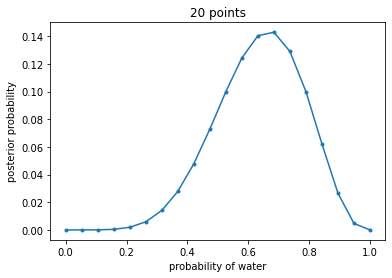

In [39]:
plt.plot(p_grid, posterior, ".-")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points');

### 2.5

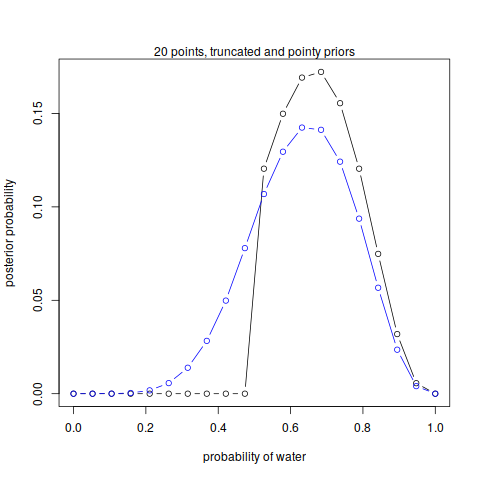

In [40]:
%%R

p_grid <- seq(from=0, to=1, length.out=20)

prior <- ifelse(p_grid < 0.5, 0, 1)
likelyhood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelyhood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)
plot(p_grid, posterior, type="b", xlab="probability of water", ylab="posterior probability")

prior <- exp(-0.5*abs(p_grid - 0.5))
likelyhood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelyhood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)
lines(p_grid, posterior, type="b", col="blue")

mtext("20 points, truncated and pointy priors")

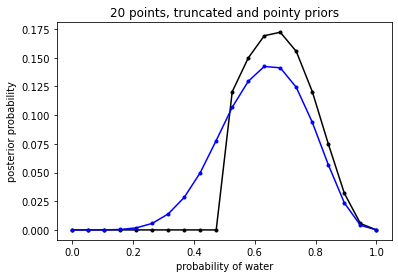

In [41]:
p_grid = tf.linspace(0., 1, 20)

prior = tf.where(p_grid < 0.5, tf.zeros_like(p_grid), tf.ones_like(p_grid))
likelyhood = zero_nans(tfd.Binomial(total_count=9, probs=p_grid).prob(6))
unnormalized_posterior = likelyhood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
plt.plot(p_grid, posterior, ".-k")

prior = tfm.exp(-0.5*tfm.abs(p_grid - 0.5))
likelyhood = zero_nans(tfd.Binomial(total_count=9, probs=p_grid).prob(6))
unnormalized_posterior = likelyhood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
plt.plot(p_grid, posterior, ".-b")

plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points, truncated and pointy priors');